# Multi-Step Financial Trading Agent using Deep Reinforcement Learning
### Project by Group 1
- **Algorithms**: DQN, PPO, SAC
- **Datasets**: Bitcoin and S&P 500 (from Kaggle)
- **Goal**: Maximize Sharpe Ratio and returns using DRL


1. Install Dependencies

In [1]:
pip install stable-baselines3 gymnasium pandas yfinance matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


2. Imports and Data Prep

In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import yfinance as yf

# Download BTC and S&P500 data
btc = yf.download('BTC-USD', start='2020-01-01', end='2024-12-31')[['Close']]
sp500 = yf.download('^GSPC', start='2020-01-01', end='2024-12-31')[['Close']]
df = pd.concat([btc, sp500], axis=1)
df.columns = ['BTC', 'S&P500']
df['BTC_return'] = df['BTC'].pct_change().fillna(0)
df['SP500_return'] = df['S&P500'].pct_change().fillna(0)
df.reset_index(drop=True, inplace=True)


C:\Users\BISS\AppData\Local\Temp\ipykernel_980\4135636762.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', start='2020-01-01', end='2024-12-31')[['Close']]
[*********************100%***********************]  1 of 1 completed
C:\Users\BISS\AppData\Local\Temp\ipykernel_980\4135636762.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2020-01-01', end='2024-12-31')[['Close']]
[*********************100%***********************]  1 of 1 completed
C:\Users\BISS\AppData\Local\Temp\ipykernel_980\4135636762.py:13: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['SP500_return'] = df['S&P500'].pct_change().fillna(0)


3. Environment

In [3]:
class MultiAssetTradingEnv(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.n_assets = 2
        self.action_space = spaces.MultiDiscrete([3] * self.n_assets)  # 0=Sell, 1=Hold, 2=Buy
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.step_idx = 0
        return self._get_obs(), {}

    def _get_obs(self):
        return np.array([
            self.df.loc[self.step_idx, 'BTC_return'],
            self.df.loc[self.step_idx, 'SP500_return']
        ], dtype=np.float32)

    def step(self, action):
        # Ensure action is a simple list of scalars
        action = np.array(action).astype(int).flatten()

        ret_btc = self.df.loc[self.step_idx, 'BTC_return']
        ret_sp = self.df.loc[self.step_idx, 'SP500_return']

        reward = 0
        if action[0] == 2: reward += ret_btc
        elif action[0] == 0: reward -= ret_btc

        if action[1] == 2: reward += ret_sp
        elif action[1] == 0: reward -= ret_sp

        self.step_idx += 1
        done = self.step_idx >= len(self.df) - 1
        obs = self._get_obs()

        return obs, reward, done, False, {}



4. Discrete Wrapper for DQN

In [4]:
class DiscreteWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.original_env = env
        self.n_assets = 2
        self.action_space = spaces.Discrete(3 ** self.n_assets)

    def step(self, action):
        multi_action = np.unravel_index(action, (3,) * self.n_assets)
        return self.original_env.step(multi_action)

    def reset(self, seed=None, options=None):
        return self.original_env.reset(seed, options)


5. Evaluation Function

In [5]:
def evaluate_model(model, env, discrete=False):
    obs, _ = env.reset()
    done = False
    rewards = []
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        if discrete:
            action = np.unravel_index(action, (3,) * env.original_env.n_assets)
        obs, reward, done, _, _ = env.step(action)
        rewards.append(reward)
    return rewards


6. Train PPO (Tuned Version)

In [6]:
from stable_baselines3 import PPO

env_ppo = MultiAssetTradingEnv(df)
model_ppo = PPO("MlpPolicy", env_ppo, verbose=1, learning_rate=3e-4, n_steps=2048)
model_ppo.learn(total_timesteps=50000)
rewards_ppo = evaluate_model(model_ppo, MultiAssetTradingEnv(df))


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.82e+03 |
|    ep_rew_mean     | -1.68    |
| time/              |          |
|    fps             | 967      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.82e+03   |
|    ep_rew_mean          | 2.03       |
| time/                   |            |
|    fps                  | 661        |
|    iterations           | 2          |
|    time_elapsed         | 6          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01083732 |
|    clip_fraction        | 0.0373     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.19

7. Train DQN

In [7]:
from stable_baselines3 import DQN

# Create and wrap the environment once
env_dqn = DiscreteWrapper(MultiAssetTradingEnv(df))

# Train the DQN model
model_dqn = DQN("MlpPolicy", env_dqn, verbose=1)
model_dqn.learn(total_timesteps=50000)

# Evaluate on the same wrapped env to avoid shape issues
rewards_dqn = evaluate_model(model_dqn, env_dqn, discrete=True)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82e+03 |
|    ep_rew_mean      | 19.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 986      |
|    time_elapsed     | 7        |
|    total_timesteps  | 7300     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000111 |
|    n_updates        | 1799     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82e+03 |
|    ep_rew_mean      | 28.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1079     |
|    time_elapsed     | 13       |
|    total_timesteps  | 14600    |
| train/              |        

9. Sharpe & Drawdown Utilities

In [8]:
def compute_sharpe(returns):
    returns = np.array(returns)
    return np.mean(returns) / (np.std(returns) + 1e-8)

def compute_max_drawdown(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns - peak
    return np.min(drawdown)


10. Plot & Compare All

C:\Users\BISS\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


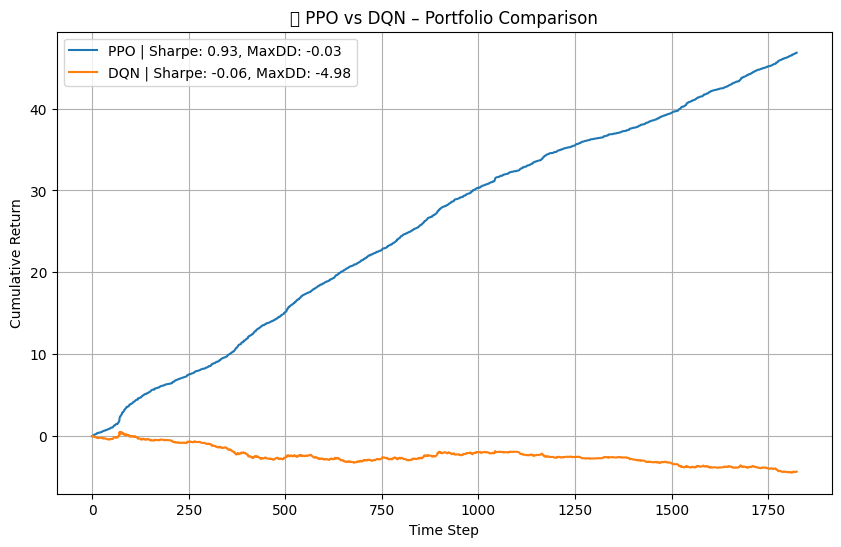

In [9]:
import matplotlib.pyplot as plt

cum_ppo = np.cumsum(rewards_ppo)
cum_dqn = np.cumsum(rewards_dqn)

plt.figure(figsize=(10, 6))
plt.plot(cum_ppo, label=f'PPO | Sharpe: {compute_sharpe(rewards_ppo):.2f}, MaxDD: {compute_max_drawdown(cum_ppo):.2f}')
plt.plot(cum_dqn, label=f'DQN | Sharpe: {compute_sharpe(rewards_dqn):.2f}, MaxDD: {compute_max_drawdown(cum_dqn):.2f}')
plt.title("✅ PPO vs DQN – Portfolio Comparison")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()


In [11]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Wrap and vectorize the environment
env_train = DummyVecEnv([lambda: DiscreteWrapper(MultiAssetTradingEnv(df))])

# Train the model
model = PPO("MlpPolicy", env_train, verbose=1)
model.learn(total_timesteps=10000)

# Save the model
model.save("ppo_trading_agent")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1019 |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 660         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009321136 |
|    clip_fraction        | 0.0263      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.19       |
|    explained_variance   | -0.0394     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00821    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0125     |
|    value_loss           | 0.00761     |
-----------------------------------------
-----------------

Decision Table

In [13]:
import numpy as np
import pandas as pd

env_eval = DiscreteWrapper(MultiAssetTradingEnv(df))
obs, _ = env_eval.reset()
done = False
log = []

action_names = ["Sell", "Hold", "Buy"]

while not done:
    action, _states = model.predict(obs, deterministic=True)
    
    # Decode to multi-asset actions
    btc_action, sp500_action = np.unravel_index(action, (3, 3))

    obs, reward, done, _, _ = env_eval.step(action)

    log.append({
        "Step": env_eval.original_env.step_idx,
        "BTC_return": obs[0],
        "SP500_return": obs[1],
        "BTC_action": action_names[btc_action],
        "SP500_action": action_names[sp500_action],
        "Reward": reward
    })

# Convert to DataFrame and display
action_log = pd.DataFrame(log)
action_log.tail(10)


,Step,BTC_return,SP500_return,BTC_action,SP500_action,Reward
1815,1816,-0.005434,0.000000,Buy,Buy,0.013587
1816,1817,-0.021803,0.000000,Sell,Hold,0.005434
1817,1818,-0.004402,0.007287,Sell,Hold,0.021803
1818,1819,0.042138,0.011043,Sell,Hold,0.004402
1819,1820,0.006315,0.000000,Buy,Hold,0.042138
1820,1821,-0.035284,-0.000406,Buy,Buy,0.006315
1821,1822,-0.017022,-0.011056,Sell,Hold,0.035284
1822,1823,0.010610,0.000000,Sell,Hold,0.017022
1823,1824,-0.017167,0.000000,Buy,Buy,0.010610
1824,1825,-0.009484,-0.010702,Sell,Hold,0.017167


Evaluate Performance with Cumulative Reward Chart

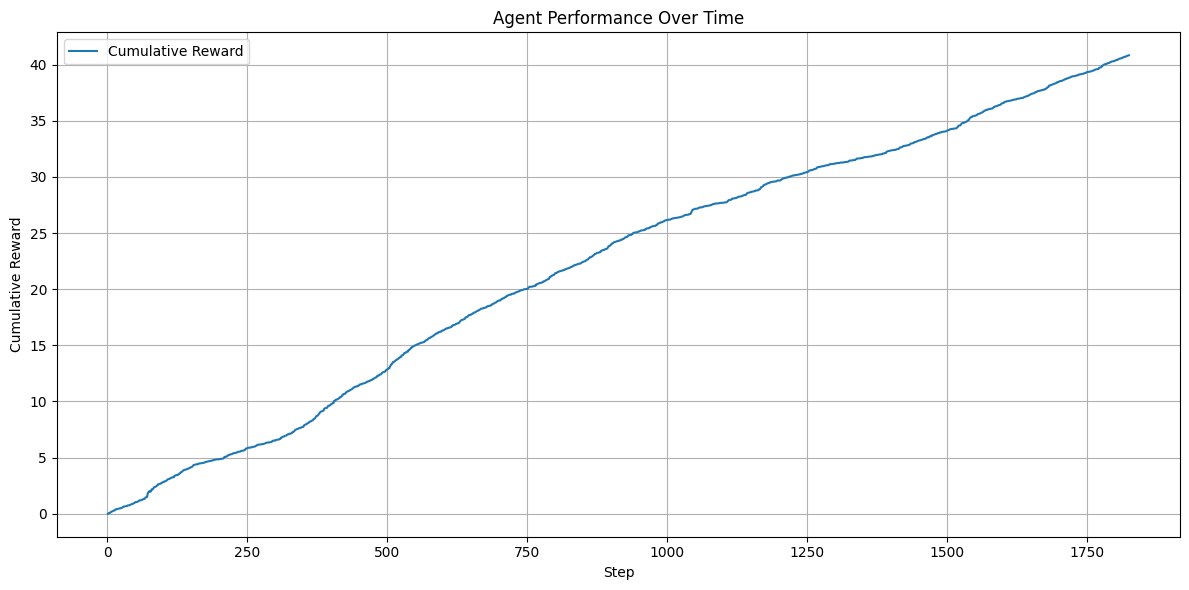

In [14]:
import matplotlib.pyplot as plt

# Plot cumulative reward over time
action_log["Cumulative_Reward"] = action_log["Reward"].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(action_log["Step"], action_log["Cumulative_Reward"], label="Cumulative Reward")
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.title("Agent Performance Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
action_log.to_csv("action_log.csv", index=False)
